<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PRA</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Práctica: Clasificador Neuronal para la detección de Glaucoma

El objetivo de esta práctica es la creación de una red neuronal que clasifique ojos en sanos o con Glaucoma a partir de 1707 imágenes etiquetadas de la retina.

Para ello en este *notebook* desarrollamos 5 modelos de clasificación haciendo *transfer-learning* de modelos preentrenados disponibles en `keras`, y *fine-tuning* de algunos de ellos. 

Por último seleccionamos el modelo que nos ha dado mejores resultados y realizamos una validación cruzada con l0 *folds* predefinidos. 

También existe un último apartado extra donde se prueba la arquitectura Xception, y que no se ha incluído en el reportaje para no extenderse demasiado y por no haber dado resultados tan buenos como los modelos sí reportados.

## Setup

Comenzamos por instalar las librerias necesarias y no pre-instaladas en *Google Colab*. 
En concreto instalamos las librerías `wanbd` y `tensorflow-addons`. 
La primera nos permite utilizar la plataforma [Weights & Biases](https://wandb.ai/), que hemos utilizado para el seguimiento de los experimentos, y la segunda nos da acceso a una implementación de la métrica *F1-Score* que utilizamos en la práctica.

In [1]:
%%capture
!pip install wandb

In [2]:
import wandb
from wandb.keras import WandbCallback

wandb.login();

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
!wandb sync --clean  # Eliminamos la información de los expermientos ya sincronizada con la web

No runs older than 24 hours found


In [4]:
%%capture
!pip install tensorflow-addons

In [5]:
from tensorflow_addons.metrics import F1Score

A continuación importamos las librerías comunes que utilizamos a lo largo de la práctica:

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
from typing import List
from sklearn.metrics import ConfusionMatrixDisplay

Y a continuación, los elementos de `tensorflow.keras` que utilizaremos:

In [7]:
# Para la creación y entrenamiento de modelos:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [8]:
# Para el data-augmentation:
from tensorflow.keras.layers import RandomRotation, RandomZoom, RandomFlip

In [9]:
# Para el transfer-learning:
from tensorflow.keras.applications import EfficientNetB0, vgg19

Definimos la función que nos permite hacer toda la práctica reproducible:

In [10]:
import tensorflow.random as tf_random
import random

In [11]:
def set_all_seeds(s):
  """Fixes numpy, tensorflow and random libraries seeds."""
  np.random.seed(s)
  tf_random.set_seed(s)
  random.seed(s)

Fijamos la semilla aleatoria:

In [12]:
set_all_seeds(1)

Fijamos también las variables de *settings*:

In [13]:
DATA_DIR = "Data"  # Directorio de donde leeremos los datos
MODELS_DIR = "Models"  # Directorio donde guardaremos los pesos de los modelos
IMAGES_SHAPE = (224, 224, 3)  # Tamaño de las imágenes que utilizaremos
MAX_BATCH_SIZE = 32  # Tamaño máximo del batch considerado
ABNORMALITY_THRESHOLD = 0.5  # Umbral de probabilidad a partir del cual se considera un caso como anormal

In [14]:
labels = ['normal', 'abnomal']
# Diccionario relacionando etiquetas con valores enteros:
label2value = {
    'normal': 0, 
    'abnormal': 1
}
# Y diccionario inverso, relacionando valores enteros con su etiqueta:
value2label = {
    0: 'normal', 
    1: 'abnormal'
}

Montamos el *drive*, que utilizaremos como disco:

In [15]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Y navegamos a la carpeta donde tenemos alojados los datos y guardaremos los modelos:

In [16]:
%cd ./drive/MyDrive/Practica_DL

/content/drive/MyDrive/Practica_DL


## 1. Análisis exploratorio de los datos (1,5 puntos)

Realizamos un análisis tanto visual como numérico de los datos. 

Para el análisis visual utilizamos el subcojunto de entrenamiento del *Fold0*, 
y en el análisis numérico estudiamos tanto este *fold* como el resto.

### Carga de datos

La función `read_glaucoma_fold_dataset()` realiza la lectura del *fold* que se le indique, 
devolviendo una matriz de *features* y un vector de *labels* para cada uno de los subconjuntos de *train*, validación y *test*:

In [17]:
from os import walk, path

In [18]:
def read_glaucoma_fold_dataset(fold: str):
  """Reads feature and label data for each subset of the fold.
  Return format is (X_train, y_train), (X_valid, y_valid), (X_test, y_test)."""
  # Obtenemos el path al directorio del fold:
  fold_path = path.join(DATA_DIR, fold)
  # Inicializamos la lista donde guardaremos las parejas (X, y)
  feature_label_tuples = []
  # Iteramos sobre subconjuntos:
  for subset in ('train', 'valid', 'test'):
    X = []
    y = []
    # y sobre las carpetas con imágenes de cada tipo:
    for label in ('normal', 'abnormal'):
      label_subset_path = path.join(fold_path, subset, label)
      # Obtenemos el listado de imágenes en el directorio:
      (_, _, filenames) = next(walk(label_subset_path))
      # Obtenemos el label entero correspondiente a la clase:
      label_value = label2value[label]
      # Leemos las imágenes y generamos X e y:
      for image_name in filenames:
        image_data = image.imread(label_subset_path + "/" + image_name)
        X.append(image_data)
        y.append(label_value)
    feature_label_tuples.append((np.array(X), np.array(y)))
  return feature_label_tuples

Aquí es interesante notar que en caso de disponer de muchos datos, leerlos de esta manera, guardando todas las imágenes a la vez en la memoria RAM, no es siempre posible. 
En estos casos puede utilizarse la función `tf.keras.utils.image_dataset_from_directory()`, 
tal y como hacen en [este tutorial de Tensorflow](https://www.tensorflow.org/tutorials/images/transfer_learning).

Como en nuestro caso cada fold ocupa algo menos de 20Mb de memoria, esto no es un problema, razón por la cual hemos optado por tener los datos en memoria.

Leemos los datos del *Fold0*:

In [19]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = read_glaucoma_fold_dataset(fold="Fold0")

### Análisis numérico del *Fold0*:

A continuación mostramos un resumen numérico de los diferentes subconjuntos del *Fold0* con los que trabajaremos:

In [20]:
# Dimensiones de los datos:
print(f"La dimensión del conjunto de features de entrenamiento es {X_train.shape}.")
print(f"La dimensión del conjunto de labels de entrenamiento es {y_train.shape}.")
print(f"La proporción de casos anormales es {round(y_train.mean(), 2)}.")

La dimensión del conjunto de features de entrenamiento es (1379, 224, 224, 3).
La dimensión del conjunto de labels de entrenamiento es (1379,).
La proporción de casos anormales es 0.45.


In [21]:
print(f"La dimensión del conjunto de features de validación es {X_valid.shape}.")
print(f"La dimensión del conjunto de labels de validación es {y_valid.shape}.")
print(f"La proporción de casos anormales en la validación es {round(y_valid.mean(), 2)}.")

La dimensión del conjunto de features de validación es (154, 224, 224, 3).
La dimensión del conjunto de labels de validación es (154,).
La proporción de casos anormales en la validación es 0.46.


In [22]:
print(f"La dimensión del conjunto de features de evaluación es {X_test.shape}.")
print(f"La dimensión del conjunto de labels de evaluación es {y_test.shape}.")
print(f"La proporción de casos anormales en el evaluación es {round(y_test.mean(), 2)}.")

La dimensión del conjunto de features de evaluación es (174, 224, 224, 3).
La dimensión del conjunto de labels de evaluación es (174,).
La proporción de casos anormales en el evaluación es 0.53.


Como podemos ver todas las imágenes son a color y del mismo tamaño, 224x224.
Los datos en las matrices de *features* varían de 0 a 255,
y los vectores con el label sólo contienen dos valores, 
el 0 para ojos sanos y el 1 para ojos con Glaucoma.

Respecto a las diferencias, 
además del número de ejemplos la más obvia es la distinta proporción de casos anormales entre distintos subconjuntos, 
que puede afectar a los resultados del modelo.

### Análisis visual del *Fold0*:

Las primeras y últimas 5 imágenes del conjunto de entrenamiento son las siguientes:

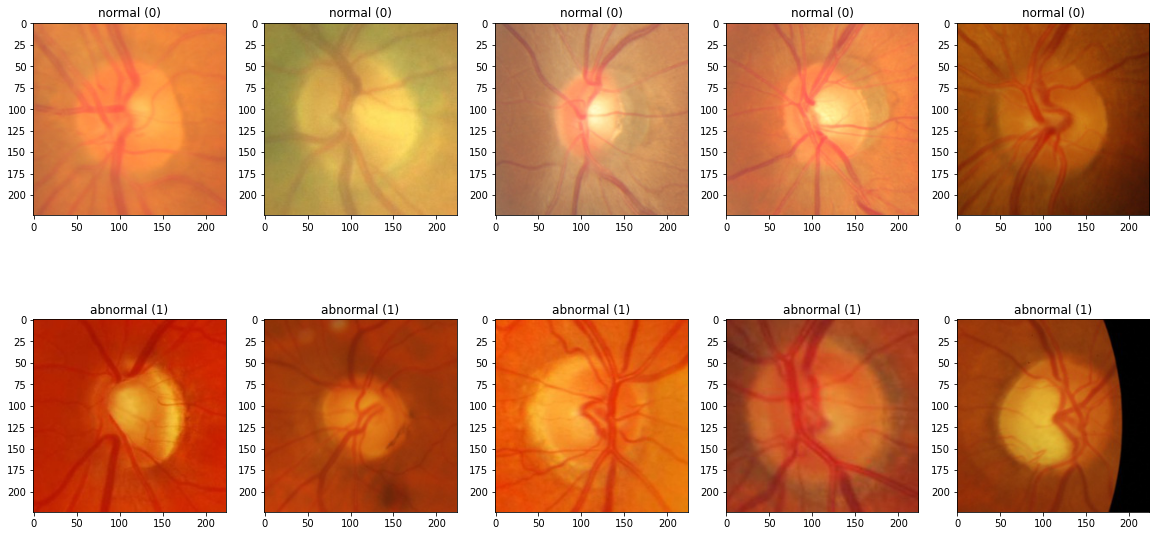

In [23]:
# Creamos el subplot:
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
  sample_image = X_train[4-i]
  # Mostramos la imagen:
  ax.imshow(sample_image)
  # Añadimos la etiqueta:
  y = y_train[4-i]
  ax.set_title(f"{value2label[y]} ({y})")
plt.show()

Como persona no experta soy incapaz de determinar si una imagen corresponde a un ojo sano o a uno con Glaucoma.
La única diferencia que puedo ver entre ambos grupos es el tono más rojizo de las imágenes anormales,
lo cual no es un atributo que realmente sirva para dividir ambos casos, 
como podemos ver a continuación al seleccionar una muestra diferente de imágenes:

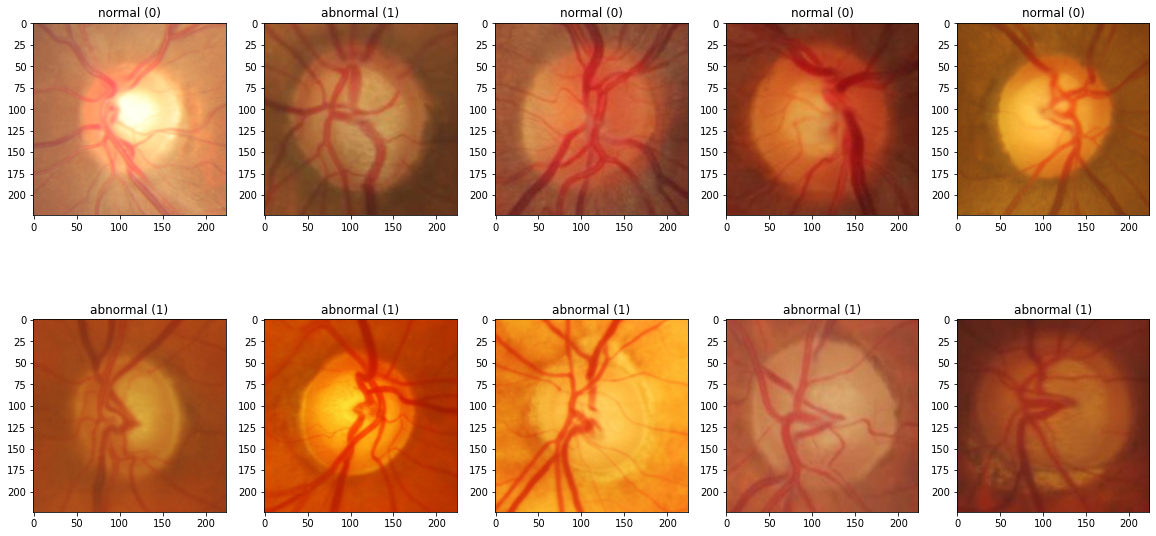

In [24]:
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
# Hacemos la selección aleatoria:
sample = random.sample(range(X_train.shape[0]), 10)
for i, ax in enumerate(axes.flat):
  sample_image = X_train[sample][i]
  # Mostramos la imagen:
  ax.imshow(sample_image)
  # Añadimos la etiqueta:
  y = y_train[sample][i]
  ax.set_title(f"{value2label[y]} ({y})")
plt.show()

Esta figura muestra además que la variedad de imágenes es mucho más amplia que la vista en la primera figura.

Por otra parte, vemos que el color de todas las imágenes es muy similar, con tono rojos y amarillos principalmente, lo cual hace muy dificil distinguir los diferentes elementos en la imagen. 

Para tratar de corregir esto provamos de utilizar la técnica de [ecualización de histogramas](https://docs.opencv.org/3.4/d4/d1b/tutorial_histogram_equalization.html) haciendo uso de la librería *OpenCV*:

In [25]:
import cv2 as cv

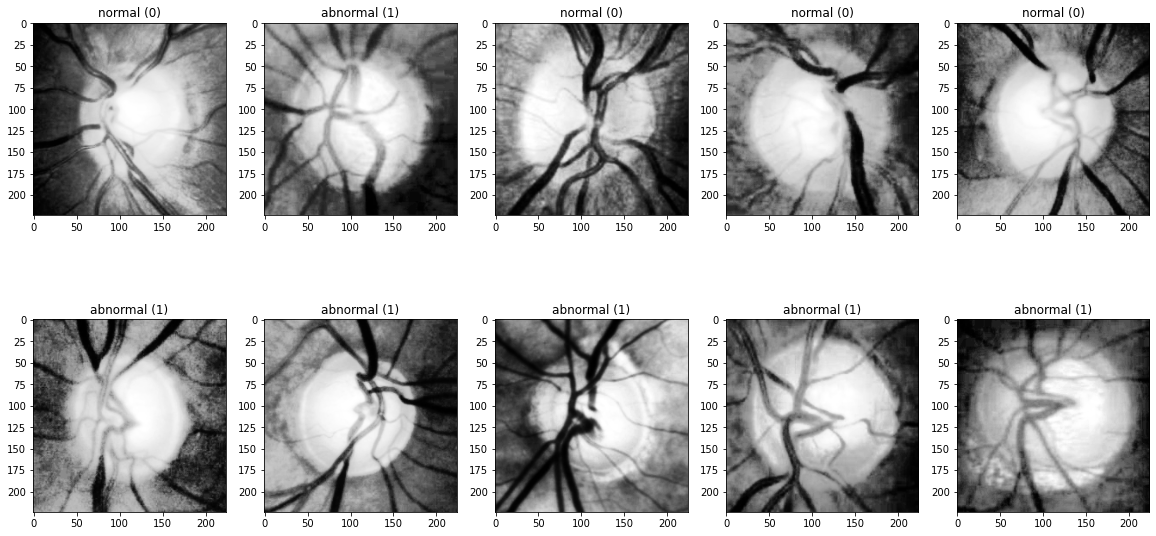

In [26]:
# Creamos el subplot:
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
  sample_image = X_train[sample][i]
  # Mostramos la imagen convertida a escala de grises y con histograma ecualizado:
  sample_image = cv.cvtColor(sample_image, cv.COLOR_BGR2GRAY)
  sample_image = cv.equalizeHist(sample_image)
  ax.imshow(sample_image, cmap='gray')
  # Añadimos la etiqueta:
  y = y_train[sample][i]
  ax.set_title(f"{value2label[y]} ({y})")
plt.show()

Como podemos ver esta técnica permite distinguir mejor el Disco Óptico del resto de la imagen, pero no parece facilitar la segmentación de Disco y Copa Óptica, por lo que decidimos quedarnos con las imágenes originales.

Estudiamos también la imagen normal media vs. la anormal media. 
Podemos ver a continuación sí que se observa un ligero tono más rojizo de media en las imágenes anormales, 
pero no hay ninguna otra diferencia obvia:

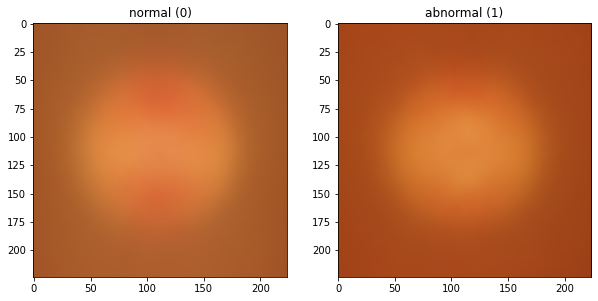

In [27]:
# Creamos el subplot:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for y, ax in zip([0, 1], axes.flat):
  mean_image = X_train[y_train==y].mean(axis=0)
  # Mostramos la imagen:
  ax.imshow(mean_image/255)
  # Añadimos la etiqueta:
  ax.set_title(f"{value2label[y]} ({y})")
plt.show()

Concluímos el análisis visual con una reflexión sobre los posibles aumentos artificiales de los datos que podemos hacer: 
parece que tendrían sentido tanto las rotaciones y volteos aleatorios como la aplicación de un pequeño (o muy pequeño) zoom,
que son las operaciones utilizadas por los autores del artículo de referencia. 
Las traslaciones, por el contrario, corren el riesgo de sacar de la imagen la parte de interés, 
la más cercana al Disco Óptico, 
por lo que no parece que sea buena idea utilizarlas.

### Análisis númerico de todos los *folds*:

Para concluir el análisis de los datos estudiamos las características numéricas de cada un de los *folds*:

In [28]:
numeric_summary = []
for i in range(10):
    fold_i = f"Fold{i}"
    print(f"Starting with {fold_i}.")
    (X_tr, y_tr), (X_val, y_val), (X_eval, y_eval) = read_glaucoma_fold_dataset(fold=fold_i)
    fold_summary = {
        "Fold": fold_i,
        "Train_X_shape": X_tr.shape,
        "Train_y_shape": y_tr.shape,
        "Train_abormals_prop": round(y_tr.mean(), 2),
        "Val_X_shape": X_val.shape,
        "Val_y_shape": y_val.shape,
        "Val_abormals_prop": round(y_val.mean(), 2),
        "Test_X_shape": X_eval.shape,
        "Test_y_shape": y_eval.shape,
        "Test_abormals_prop": round(y_eval.mean(), 2)
    }
    numeric_summary.append(fold_summary)
numeric_summary_df = pd.DataFrame.from_records(numeric_summary)

Starting with Fold0.
Starting with Fold1.
Starting with Fold2.
Starting with Fold3.
Starting with Fold4.
Starting with Fold5.
Starting with Fold6.
Starting with Fold7.
Starting with Fold8.
Starting with Fold9.


In [29]:
numeric_summary_df

,Fold,Train_X_shape,Train_y_shape,Train_abormals_prop,Val_X_shape,Val_y_shape,Val_abormals_prop,Test_X_shape,Test_y_shape,Test_abormals_prop
0,Fold0,"(1379, 224, 224, 3)","(1379,)",0.45,"(154, 224, 224, 3)","(154,)",0.46,"(174, 224, 224, 3)","(174,)",0.53
1,Fold1,"(1382, 224, 224, 3)","(1382,)",0.46,"(154, 224, 224, 3)","(154,)",0.43,"(174, 224, 224, 3)","(174,)",0.48
2,Fold2,"(1386, 224, 224, 3)","(1386,)",0.47,"(154, 224, 224, 3)","(154,)",0.46,"(174, 224, 224, 3)","(174,)",0.44
3,Fold3,"(1379, 224, 224, 3)","(1379,)",0.46,"(154, 224, 224, 3)","(154,)",0.45,"(174, 224, 224, 3)","(174,)",0.48
4,Fold4,"(1379, 224, 224, 3)","(1379,)",0.46,"(154, 224, 224, 3)","(154,)",0.47,"(174, 224, 224, 3)","(174,)",0.47
5,Fold5,"(1379, 224, 224, 3)","(1379,)",0.45,"(154, 224, 224, 3)","(154,)",0.54,"(174, 224, 224, 3)","(174,)",0.48
6,Fold6,"(1379, 224, 224, 3)","(1379,)",0.45,"(154, 224, 224, 3)","(154,)",0.45,"(174, 224, 224, 3)","(174,)",0.53
7,Fold7,"(1379, 224, 224, 3)","(1379,)",0.47,"(154, 224, 224, 3)","(154,)",0.47,"(174, 224, 224, 3)","(174,)",0.43
8,Fold8,"(1379, 224, 224, 3)","(1379,)",0.46,"(154, 224, 224, 3)","(154,)",0.48,"(174, 224, 224, 3)","(174,)",0.48
9,Fold9,"(1379, 224, 224, 3)","(1379,)",0.47,"(154, 224, 224, 3)","(154,)",0.47,"(174, 224, 224, 3)","(174,)",0.40


Como podemos ver las principales anomalías son el diferente número de ejemplos de entrenamiento en los *folds* 1 y 2, por una parte, 
y la variabilidad de la proporción de casos anormales en el conjunto de test, que como ya hemos comentado puede afectar a los resultados del modelo.

## 2. Entrenamiento de una red neuronal sobre una única partición [4 puntos]

Para poder obtener conclusiones preliminares en un plazo razonable de tiempo comenzamos evaluando 5 modelos distintos en un único *fold*, el *Fold0*.

Para la implementación de las redes de *transfer-learning* y el *fine-tuning* de los modelos nos basamos en las múltiples guías presentes en las webs de *Tensorflow* y *Keras*:
+ https://www.tensorflow.org/guide/keras/transfer_learning
+ https://www.tensorflow.org/tutorials/images/transfer_learning
+ https://keras.io/guides/transfer_learning/
+ https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

Por otra parte, como ya hemos mencionado hemos utilizado el servicio  [*Weights & Biases*](https://www.wandb.ai) para hacer el seguimiento de los diferentes experimentos. 
Para implementar su uso en este notebook hemos seguido [esta guía introductoría](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/intro/Intro_to_Weights_%26_Biases.ipynb).

Comenzamos definiendo varias funciones auxiliares que utilizaremos durante el resto de la práctica:

#### Model checkpoints

Definimos la función `get_model_checkpoint()`, 
que devuelve un *callback* que guarda en el directorio que le indicamos los pesos del mejor modelo, 
el cual selecciona basándose en la *F1-Score* de validación:

In [30]:
def get_model_checkpoint(file_path: str):
  """Return model checkpoint that saves the best models weights based on validation F1-Score."""
  callback = ModelCheckpoint(
      filepath=file_path,
      monitor='val_f1_score',
      mode='max',
      save_best_only=True,
      save_only_weights=True
  )
  return callback

#### Gráficas del aprendizaje

Definimos la función `plot_prediction()`, que dibuja las gráficas de *loss*, *accuracy* y *F1-Score* a partir del *log* creado entrenando el modelo (`mfit`) y desde la época cero hasta la indicada mediante el argumento `n_epochs`, si esta disponible:

In [31]:
# Plot del training loss y el accuracy
def plot_prediction(n_epochs, mfit):
  """
  Draws loss, accuracy and F1-score plots from epoch 0 to n_epochs.
  """
  figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 5))
  for ax, measure in zip(axes, ['loss', 'accuracy', 'f1_score']):
    ax.plot(mfit.history[measure][:n_epochs])
    ax.plot(mfit.history['val_' + measure][:n_epochs])
    ax.set_title(f'Model {measure}')
    ax.set_ylabel(measure)
    ax.set_xlabel('Epoch')
    ax.legend([f'Train {measure}', f'Test {measure}'])
  plt.show()
  pass

#### Data augmentation

Definimos la función `data_augmentation_pipeline()`, que devuelve un modelo que efectua las transformaciones de *data-augmentation* que hemos visto adecuadas en la sección de exploración visual:

In [32]:
def data_augmentation_pipeline():
  """Return sequential model that performs the augmentation of training data."""
  data_augmentation = Sequential([
        RandomRotation(factor=0.15),
        RandomZoom((0, 0.2)),
        RandomFlip(),
        ])
  return data_augmentation

Para realizar este aumento artificial de los datos hemos seguido [este tutorial de Tensorflow](https://www.tensorflow.org/tutorials/images/data_augmentation).

#### Descongelador de capas de modelos preentrenados

Definimos la función `make_base_models_last_n_layers_trainable()`, que convierte las últimas `n_layers` capas de la capa `base_model_name` del modelo `model` en entrenables (con la excepción de las capas *BatchNormalization*):

In [33]:
def make_base_models_last_n_layers_trainable(model, 
                                             base_model_name: str, 
                                             n_layers: int = None):
  """Make the last n_layers of the layer base_model_name of the model trainable."""
  # If n_layers is None we set the whole network to trainable:
  if n_layers is None:
    n_layers = 0
  # We get the base model and set it as trainable, 
  # making all its layers trainable:
  base_model = model.get_layer(name=base_model_name)
  base_model.trainable = True
  # We re-set the BatchNormalization layers to non-trainable:
  trainable_layers = base_model.layers[(-n_layers):]
  for layer in filter(lambda x: isinstance(x, BatchNormalization), trainable_layers):
    layer.trainable = False
  # We re-set the layers we don't want to train:
  non_trainable_layers = base_model.layers[:(-n_layers)]
  for layer in non_trainable_layers:
    layer.trainable = False

### Modelos basados en la EfficientNet B0

En estos modelos no utilizaremos el aumento artificial de datos, por lo que lo desactivamos:

In [34]:
DATA_AUGMENTATION = False

Definimos la función `efficientnet_transfer_model()`, 
que devuelve un modelo de *transfer-learning* del modelo preentrenado *EfficientNet B0* con las capas de clasificación indicadas en el enunciado:

In [35]:
def efficientnet_transfer_model():
  inputs = Input(shape=IMAGES_SHAPE)
  # Augmentation of data, if active:
  if DATA_AUGMENTATION:
    data_augmentation_model = data_augmentation_pipeline()
    augmented_inputs = data_augmentation_model(inputs)
  else:
    augmented_inputs = inputs
  # EfficientNet does not require any preprocessing.
  # We get the Efficient Net:
  base_model = EfficientNetB0(
    include_top=False, # Do not include the ImageNet classifier at the top.
    weights="imagenet", # Load weights pre-trained on ImageNet.
    input_shape=IMAGES_SHAPE # Shape of the data
  )
  # We set the Efficient Net to not trainable:
  base_model.trainable = False
  # We add the new layers on top:
  new_layers = base_model(augmented_inputs, training=False)
  new_layers = GlobalAveragePooling2D()(new_layers)
  new_layers = BatchNormalization()(new_layers)
  new_layers = Dropout(0.2)(new_layers)
  outputs = Dense(1, activation='sigmoid')(new_layers)
  model = Model(inputs=inputs, outputs=outputs)
  return model

#### Modelo 1: entrenamiento exclusivo de las capas de clasificación

Iniciamos el experimento y su seguimiento a través de *Weights & Biases*, fijando para ello la configuración que utilizaremos:

In [36]:
# Initialize wandb with your project name
model_1_run = wandb.init(project='Practica-DL-Modelo-1',
                 config={  # and include hyperparameters and metadata
                     "optimizer": 'Adam',
                     "learning_rate": 0.001,
                     "epochs": 100,
                     "batch_size": MAX_BATCH_SIZE,
                     "data_augmentation": DATA_AUGMENTATION,
                     "early_stopping_p": 20,
                     "loss_function": "binary_crossentropy",
                     'model': 'model_1',
                     'base_model_name': "efficientnetb0"
                 })
model_1_config = wandb.config  # We'll use this to configure our experiment

wandb: Currently logged in as: aelkoroaristizabal. Use `wandb login --relogin` to force relogin


Fijamos las semillas aleatorias:

In [37]:
set_all_seeds(10)

Creamos el modelo de *transfer-learning*:

In [38]:
model_1 = efficientnet_transfer_model()

16719872/16705208 [==============================] - 0s 0us/step


Compilamos el modelo utilizando el optimizador indicado en la configuración y las métricas *accuracy* y *F1-Score*:

In [39]:
# Compile
model_1.compile(loss=model_1_config.loss_function, 
                  optimizer=eval(model_1_config.optimizer)(learning_rate=model_1_config.learning_rate), 
                  metrics=['accuracy', F1Score(num_classes=2, average='micro', threshold=ABNORMALITY_THRESHOLD)])

Creamos el *Model Checkpoint Callback* que guardará los pesos de la mejor época durante el entrenamiento:

In [40]:
model_1_checkpoint_filepath = path.join(MODELS_DIR, 'model_1')
model_1_checkpoint_callback = get_model_checkpoint(model_1_checkpoint_filepath)

Entrenamos el modelo:

In [41]:
# Entrenar el modelo
model_1_log = model_1.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=model_1_config.epochs, 
                    batch_size=model_1_config.batch_size,
                    callbacks=[model_1_checkpoint_callback, 
                               EarlyStopping(monitor='val_loss', mode="min", 
                                             patience=model_1_config.early_stopping_p),
                               WandbCallback(monitor="val_f1_score", mode='max', save_model=False)])

Epoch 1/100
44/44 [==============================] - 70s 1s/step - loss: 0.5785 - accuracy: 0.7056 - f1_score: 0.6678 - val_loss: 0.6008 - val_accuracy: 0.6753 - val_f1_score: 0.5000 - _timestamp: 1654757878.0000 - _runtime: 87.0000
Epoch 2/100
44/44 [==============================] - 49s 1s/step - loss: 0.4425 - accuracy: 0.8165 - f1_score: 0.7938 - val_loss: 0.5552 - val_accuracy: 0.7208 - val_f1_score: 0.6055 - _timestamp: 1654757928.0000 - _runtime: 137.0000
Epoch 3/100
44/44 [==============================] - 51s 1s/step - loss: 0.3833 - accuracy: 0.8281 - f1_score: 0.8075 - val_loss: 0.5288 - val_accuracy: 0.7273 - val_f1_score: 0.6250 - _timestamp: 1654757978.0000 - _runtime: 187.0000
Epoch 4/100
44/44 [==============================] - 50s 1s/step - loss: 0.3720 - accuracy: 0.8339 - f1_score: 0.8143 - val_loss: 0.5059 - val_accuracy: 0.7532 - val_f1_score: 0.6607 - _timestamp: 1654758028.0000 - _runtime: 237.0000
Epoch 5/100
44/44 [==============================] - 51s 1s/step 

Cargamos la época con el mejor resultado:

In [42]:
model_1.load_weights(model_1_checkpoint_filepath)

Dibujamos las gráficas de *loss*, *accuracy* y *F1-Score*:

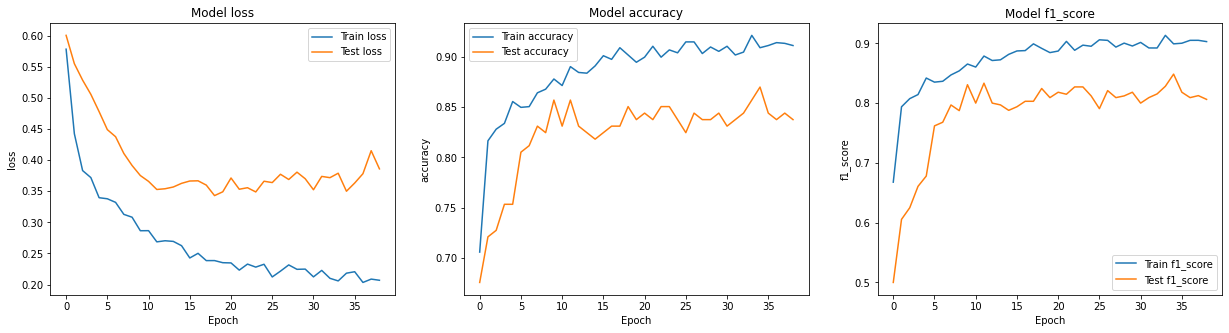

In [43]:
plot_prediction(model_1_config.epochs, model_1_log)

Evaluamos también el modelo obtenido sobre el conjunto de test:

In [44]:
model_1_loss, model_1_accuracy, model_1_f1_score = model_1.evaluate(X_test, y_test, verbose=1);

6/6 [==============================] - 0s 66ms/step - loss: 0.4116 - accuracy: 0.8448 - f1_score: 0.8421


Y mostramos la matriz de confusión sobre datos de test:

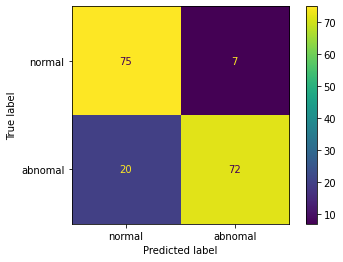

In [45]:
# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                        y_pred=model_1.predict(X_test) > ABNORMALITY_THRESHOLD, 
                                        display_labels=labels);

Guardamos el nombre del experimento, para poder hacerle seguimiento en el Modelo 2:

In [46]:
model_1_run_name = wandb.run.name

Y por último registramos los resultados y concluímos el experimento:

In [47]:
wandb.log({'test_loss': round(model_1_loss, 2),
           'test_accuracy': round(model_1_accuracy, 2),
           'test_f1_score': round(model_1_f1_score, 2)})

model_1_run.finish()

accuracy,▁▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇█▇▇▇█▇█▇██▇█▇█▇▇██████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇█▇▇▇█▇█▇██▇█▇█▇▇██████
loss,█▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_f1_score,▁
test_loss,▁
val_accuracy,▁▃▃▄▄▆▆▇▆█▇█▇▆▆▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇██▇▇▇▇
val_f1_score,▁▃▄▄▅▆▆▇▇█▇█▇▇▇▇▇▇█▇▇▇██▇▇▇▇▇▇▇▇▇██▇▇▇▇
val_loss,█▇▆▅▅▄▄▃▂▂▂▁▁▁▂▂▂▁▁▁▂▁▁▁▂▂▂▂▂▂▁▂▂▂▁▂▂▃▂
accuracy,0.91153


#### Modelo 2: capas de clasificación + 20 de la original

Iniciamos el experimento y su seguimiento a través de *Weights & Biases*, fijando para ello la configuración que utilizaremos:

In [48]:
# Initialize wandb with your project name
model_2_run = wandb.init(project='Practica-DL-Modelo-2',
                 config={  # and include hyperparameters and metadata
                     "optimizer": 'SGD',
                     "learning_rate": 0.01,
                     "momentum": 0.9,
                     "epochs": 50,
                     "batch_size": MAX_BATCH_SIZE//2,
                     "data_augmentation": DATA_AUGMENTATION,
                     "early_stopping_p": 15,
                     "loss_function": "binary_crossentropy",
                     'model': 'model_2',
                     'model_1_run': model_1_run_name,
                     'base_model_name': "efficientnetb0"
                 })
model_2_config = wandb.config  # We'll use this to configure our experiment

Fijamos las semillas aleatorias:

In [49]:
set_all_seeds(20)

Creamos el modelo de *transfer-learning*:

In [50]:
model_2 = efficientnet_transfer_model()

Cargamos los pesos del Modelo 1 ya entrenado:

In [51]:
model_2.load_weights(model_1_checkpoint_filepath)

Mostramos los resultados iniciales sobre el conjunto de validación:

In [52]:
_ = model_1.evaluate(X_valid, y_valid, verbose=1);

5/5 [==============================] - 1s 41ms/step - loss: 0.3501 - accuracy: 0.8701 - f1_score: 0.8485


Convertimos las últimas 20 capas del modelo base (la *EfficientNet B0*) en entrenables (con la excepción de las *BatchNormalization*):

In [53]:
make_base_models_last_n_layers_trainable(model=model_2, 
                                         base_model_name=model_2_config.base_model_name, 
                                         n_layers=20)

Mostramos que efectivamente ahora estas capas sí son entrenables:

In [54]:
for layer in model_2.get_layer(name=model_2_config.base_model_name).layers:
  print(layer.name, ":", layer.trainable)

input_4 : False
rescaling_1 : False
normalization_1 : False
stem_conv_pad : False
stem_conv : False
stem_bn : False
stem_activation : False
block1a_dwconv : False
block1a_bn : False
block1a_activation : False
block1a_se_squeeze : False
block1a_se_reshape : False
block1a_se_reduce : False
block1a_se_expand : False
block1a_se_excite : False
block1a_project_conv : False
block1a_project_bn : False
block2a_expand_conv : False
block2a_expand_bn : False
block2a_expand_activation : False
block2a_dwconv_pad : False
block2a_dwconv : False
block2a_bn : False
block2a_activation : False
block2a_se_squeeze : False
block2a_se_reshape : False
block2a_se_reduce : False
block2a_se_expand : False
block2a_se_excite : False
block2a_project_conv : False
block2a_project_bn : False
block2b_expand_conv : False
block2b_expand_bn : False
block2b_expand_activation : False
block2b_dwconv : False
block2b_bn : False
block2b_activation : False
block2b_se_squeeze : False
block2b_se_reshape : False
block2b_se_reduce : 

Compilamos el modelo:

In [55]:
# Compile
model_2.compile(loss=model_2_config.loss_function, 
                  optimizer=eval(model_2_config.optimizer)(learning_rate=model_2_config.learning_rate, momentum=model_2_config.momentum), 
                  metrics=['accuracy', F1Score(num_classes=2, average='micro', threshold=ABNORMALITY_THRESHOLD)])

Creamos el *Model Checkpoint Callback* que guardará los pesos de la mejor época durante el entrenamiento:

In [56]:
model_2_checkpoint_filepath = path.join(MODELS_DIR, 'model_2')
model_2_checkpoint_callback = get_model_checkpoint(model_2_checkpoint_filepath)

Y entrenamos el modelo:

In [57]:
# Entrenar el modelo
model_2_log = model_2.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=model_2_config.epochs, 
                    batch_size=model_2_config.batch_size,
                    callbacks=[model_2_checkpoint_callback, 
                               EarlyStopping(monitor='val_loss', mode="min", patience=model_2_config.early_stopping_p),
                               WandbCallback(monitor="val_f1_score", mode="max", save_model=False)])

Epoch 1/50
87/87 [==============================] - 63s 634ms/step - loss: 0.2824 - accuracy: 0.8847 - f1_score: 0.8698 - val_loss: 0.4040 - val_accuracy: 0.8182 - val_f1_score: 0.8082 - _timestamp: 1654758525.0000 - _runtime: 77.0000
Epoch 2/50
87/87 [==============================] - 3s 33ms/step - loss: 0.2336 - accuracy: 0.9094 - f1_score: 0.8999 - val_loss: 0.5682 - val_accuracy: 0.7597 - val_f1_score: 0.7673 - _timestamp: 1654758528.0000 - _runtime: 80.0000
Epoch 3/50
87/87 [==============================] - 51s 598ms/step - loss: 0.1882 - accuracy: 0.9188 - f1_score: 0.9103 - val_loss: 0.3711 - val_accuracy: 0.8571 - val_f1_score: 0.8382 - _timestamp: 1654758579.0000 - _runtime: 131.0000
Epoch 4/50
87/87 [==============================] - 3s 32ms/step - loss: 0.1481 - accuracy: 0.9405 - f1_score: 0.9340 - val_loss: 0.4199 - val_accuracy: 0.8312 - val_f1_score: 0.7903 - _timestamp: 1654758582.0000 - _runtime: 134.0000
Epoch 5/50
87/87 [==============================] - 3s 32ms/st

Cargamos la época con el mejor resultado:

In [58]:
model_2.load_weights(model_2_checkpoint_filepath)

Dibujamos las gráficas de *loss*, *accuracy* y *F1-Score*:

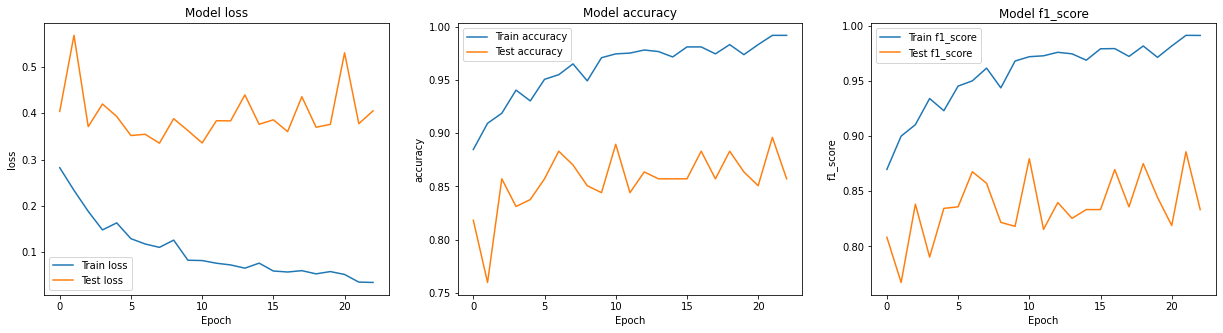

In [59]:
plot_prediction(model_2_config.epochs, model_2_log)

Evaluamos también el modelo obtenido sobre el conjunto de test:

In [60]:
model_2_loss, model_2_accuracy, model_2_f1_score = model_2.evaluate(X_test, y_test, verbose=1);

6/6 [==============================] - 0s 38ms/step - loss: 0.4225 - accuracy: 0.8851 - f1_score: 0.8901


Y mostramos la matriz de confusión sobre datos de test:

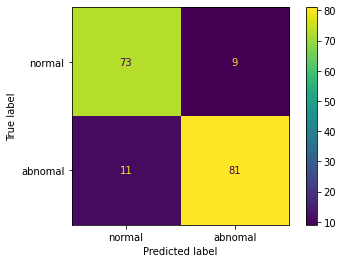

In [61]:
# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                        y_pred=model_2.predict(X_test) > ABNORMALITY_THRESHOLD, 
                                        display_labels=labels);

Guardamos el nombre del experimento para poder hacerle el seguimiento completo al Modelo 3:

In [62]:
model_2_run_name = wandb.run.name

Y por último registramos los resultados y concluímos el experimento:

In [63]:
wandb.log({'test_loss': round(model_2_loss, 2),
           'test_accuracy': round(model_2_accuracy, 2),
           'test_f1_score': round(model_2_f1_score, 2)})

model_2_run.finish()

accuracy,▁▃▃▅▄▅▆▆▅▇▇▇▇▇▇▇▇▇▇▇▇██
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
f1_score,▁▃▃▅▄▅▆▆▅▇▇▇▇▇▇▇▇▇▇▇▇██
loss,█▇▅▄▅▄▃▃▄▂▂▂▂▂▂▂▂▂▂▂▁▁▁
test_accuracy,▁
test_f1_score,▁
test_loss,▁
val_accuracy,▄▁▆▅▅▆▇▇▆▅█▅▆▆▆▆▇▆▇▆▆█▆
val_f1_score,▃▁▅▂▅▅▇▆▄▄█▄▅▄▅▅▇▅▇▆▄█▅
val_loss,▃█▂▄▃▁▂▁▃▂▁▂▂▄▂▃▂▄▂▂▇▂▃
accuracy,0.99202


#### Modelo 3: red completa

Iniciamos el experimento y su seguimiento a través de *Weights & Biases*, fijando para ello la configuración que utilizaremos:

In [64]:
# Initialize wandb with your project name
model_3_run = wandb.init(project='Practica-DL-Modelo-3',
                 config={  # and include hyperparameters and metadata
                     "optimizer": 'SGD',
                     "learning_rate": 1e-4,
                     "momentum": 0.9,
                     "clipnorm": 0.5,
                     "epochs": 25,
                     "batch_size": MAX_BATCH_SIZE,
                     "loss_function": "binary_crossentropy",
                     "data_augmentation": DATA_AUGMENTATION,
                     "early_stopping_p": 10,
                     'model': 'model_3',
                     'model_1_run': model_2_run_name,
                     'base_model_name': "efficientnetb0"
                 })
model_3_config = wandb.config  # We'll use this to configure our experiment

Fijamos las semillas aleatorias:

In [65]:
set_all_seeds(30)

Creamos el modelo de *transfer-learning*:

In [66]:
model_3 = efficientnet_transfer_model()

Cargamos los pesos del Modelo 2 ya entrenado:

In [67]:
model_3.load_weights(model_2_checkpoint_filepath)

Mostramos los resultados iniciales sobre el conjunto de validación:

In [68]:
_ = model_2.evaluate(X_valid, y_valid, verbose=1);

5/5 [==============================] - 1s 41ms/step - loss: 0.3776 - accuracy: 0.8961 - f1_score: 0.8857


Convertimos todas las capas del modelo base (la *EfficientNet B0*) en entrenables (con la excepción de las *BatchNormalization*):

In [69]:
make_base_models_last_n_layers_trainable(model=model_3, base_model_name='efficientnetb0')

Compilamos el modelo:

In [70]:
# Compile
model_3.compile(loss='binary_crossentropy', 
                  optimizer=eval(model_3_config.optimizer)(learning_rate=model_3_config.learning_rate, 
                                                           momentum=model_3_config.momentum, 
                                                           clipnorm=model_3_config.clipnorm), 
                  metrics=['accuracy', F1Score(num_classes=2, average='micro', threshold=ABNORMALITY_THRESHOLD)])

Creamos el *Model Checkpoint Callback* que guardará los pesos de la mejor época durante el entrenamiento:

In [71]:
model_3_checkpoint_filepath = path.join(MODELS_DIR, 'model_3')
model_3_checkpoint_callback = get_model_checkpoint(model_3_checkpoint_filepath)

Y entrenamos el modelo:

In [72]:
# Entrenar el modelo
model_3_log = model_3.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=model_3_config.epochs, 
    batch_size=model_3_config.batch_size, 
    callbacks=[model_3_checkpoint_callback,
               EarlyStopping(monitor='val_loss', mode="min", 
                             patience=model_3_config.early_stopping_p), 
               WandbCallback(monitor="val_f1_score", mode="max", save_model=False)]
)

Epoch 1/25
44/44 [==============================] - 75s 1s/step - loss: 0.0370 - accuracy: 0.9913 - f1_score: 0.9904 - val_loss: 0.4726 - val_accuracy: 0.8377 - val_f1_score: 0.8387 - _timestamp: 1654758882.0000 - _runtime: 91.0000
Epoch 2/25
44/44 [==============================] - 11s 241ms/step - loss: 0.0491 - accuracy: 0.9855 - f1_score: 0.9840 - val_loss: 0.5640 - val_accuracy: 0.8247 - val_f1_score: 0.7769 - _timestamp: 1654758893.0000 - _runtime: 102.0000
Epoch 3/25
44/44 [==============================] - 10s 237ms/step - loss: 0.0293 - accuracy: 0.9920 - f1_score: 0.9912 - val_loss: 1.0071 - val_accuracy: 0.7792 - val_f1_score: 0.6964 - _timestamp: 1654758903.0000 - _runtime: 112.0000
Epoch 4/25
44/44 [==============================] - 10s 239ms/step - loss: 0.0305 - accuracy: 0.9898 - f1_score: 0.9888 - val_loss: 1.4588 - val_accuracy: 0.7273 - val_f1_score: 0.5882 - _timestamp: 1654758914.0000 - _runtime: 123.0000
Epoch 5/25
44/44 [==============================] - 60s 1s/s

Cargamos la época con el mejor resultado:

In [73]:
model_3.load_weights(model_3_checkpoint_filepath)

Dibujamos las gráficas de *loss*, *accuracy* y *F1-Score*:

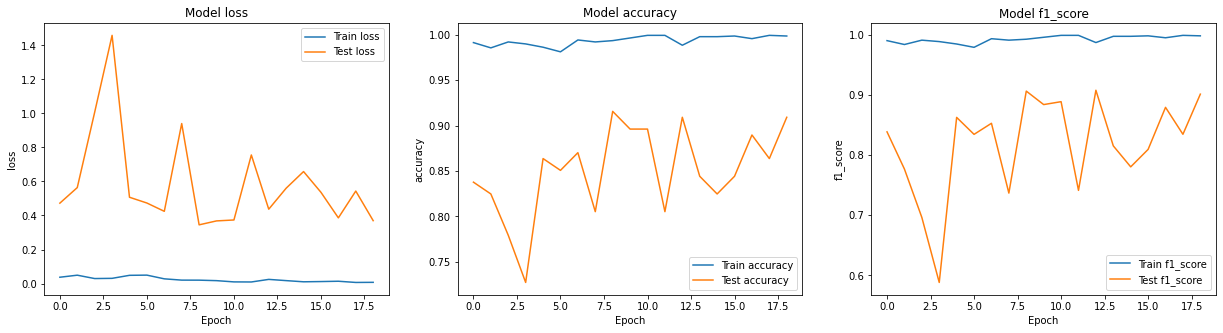

In [74]:
plot_prediction(model_3_config.epochs, model_3_log)

Evaluamos también el modelo obtenido sobre el conjunto de test:

In [75]:
model_3_loss, model_3_accuracy, model_3_f1_score = model_3.evaluate(X_test, y_test, verbose=1);

6/6 [==============================] - 0s 38ms/step - loss: 0.4622 - accuracy: 0.8851 - f1_score: 0.8969


Y mostramos la matriz de confusión sobre datos de test:

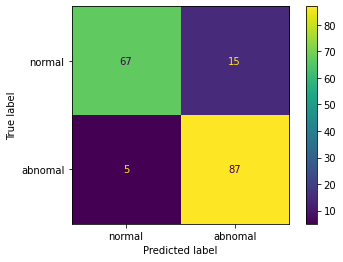

In [76]:
# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                        y_pred=model_3.predict(X_test) > ABNORMALITY_THRESHOLD, 
                                        display_labels=labels);

Y por último registramos los resultados y concluímos el experimento:

In [77]:
wandb.log({'test_loss': round(model_3_loss, 2),
           'test_accuracy': round(model_3_accuracy, 2),
           'test_f1_score': round(model_3_f1_score, 2)})

model_3_run.finish()

accuracy,▅▃▅▄▃▁▆▅▆▇██▄▇▇█▇██
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
f1_score,▅▃▅▄▃▁▆▅▆▇██▄▇▇█▇██
loss,▆█▅▅██▄▃▃▃▂▁▄▃▂▂▂▁▁
test_accuracy,▁
test_f1_score,▁
test_loss,▁
val_accuracy,▅▅▃▁▆▆▆▄█▇▇▄█▅▅▅▇▆█
val_f1_score,▆▅▃▁▇▆▇▄█▇█▄█▆▅▆▇▆█
val_loss,▂▂▅█▂▂▁▅▁▁▁▄▂▂▃▂▁▂▁
accuracy,0.99855


### Modelos 4 y 5: transfer learning + fine-tuning a partir de VGG19

Definimos la función `VGG19_transfer_model()`, 
que devuelve un modelo de *transfer-learning* del modelo preentrenado *VGG-19* y las capas de clasificación que le añadimos:

In [78]:
def VGG19_transfer_model():
  inputs = Input(shape=IMAGES_SHAPE)
  if DATA_AUGMENTATION:
    data_augmentation_model = data_augmentation_pipeline()
    augmented_inputs = data_augmentation_model(inputs)
  else:
    augmented_inputs = inputs
  preprocessed_inputs = vgg19.preprocess_input(augmented_inputs)
  # We get the VGG19:
  base_model = vgg19.VGG19(
    include_top=False, # Do not include the ImageNet classifier at the top.
    weights="imagenet", # Load weights pre-trained on ImageNet.
    input_shape=IMAGES_SHAPE # Shape of the data,
  )
  # We set the VGG19 to not trainable:
  base_model.trainable = False
  # We add the new layers on top:
  new_layers = base_model(preprocessed_inputs, training=False)
  new_layers = GlobalAveragePooling2D()(new_layers)
  new_layers = BatchNormalization()(new_layers)
  new_layers = Dropout(0.2)(new_layers)
  outputs = Dense(1, activation='sigmoid')(new_layers)
  model = Model(inputs=inputs, outputs=outputs)
  return model

Activamos el aumento artificial de datos, dado que los modelos 4 y 5 sí que lo utilizan:

In [79]:
DATA_AUGMENTATION = True

Iniciamos el experimento y su seguimiento a través de *Weights & Biases*, fijando para ello la configuración que utilizaremos:

In [80]:
# Initialize wandb with your project name
model_45_run = wandb.init(project='Practica-DL-Modelo-VGG19',
                  config={  # and include hyperparameters and metadata
                      "optimizer": 'Adam',
                      "learning_rate": 0.001,
                      "epochs": 100,
                      "batch_size": MAX_BATCH_SIZE//2,
                      'early_stopping_p1': 10,
                      "loss_function": "binary_crossentropy",
                      'model': 'model_VGG19',
                      'data_augmentation': DATA_AUGMENTATION,
                      'base_model_name': 'vgg19',
                      'fine_tuned_blocks': 2,
                      'fine_tuning_epochs': 50,
                      'fine_tuning_lr': 0.001, 
                      'fine_tuning_momentum': 0.9,
                      'fine_tuning_clipnorm': 1,
                      'early_stopping_p2': 10
                  })
model_45_config = wandb.config  # We'll use this to configure our experiment

Fijamos las semillas aleatorias:

In [81]:
set_all_seeds(40)

Creamos el modelo de *transfer-learning*:

In [82]:
model_45 = VGG19_transfer_model()

80150528/80134624 [==============================] - 0s 0us/step


Compilamos el modelo:

In [83]:
# Compile
model_45.compile(loss=model_45_config.loss_function, 
                  optimizer=eval(model_45_config.optimizer)(learning_rate=model_45_config.learning_rate), 
                  metrics=['accuracy', F1Score(num_classes=2, average='micro', threshold=ABNORMALITY_THRESHOLD)])

Creamos el *Model Checkpoint Callback* que guardará los pesos de la mejor época durante el entrenamiento:

In [84]:
model_4_checkpoint_filepath = path.join(MODELS_DIR, 'model_4')
model_4_checkpoint_callback = get_model_checkpoint(model_4_checkpoint_filepath)

Y entrenamos el modelo:

In [85]:
# Entrenar el modelo
model_4_log = model_45.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=model_45_config.epochs,
                    batch_size=model_45_config.batch_size,
                    callbacks=[model_4_checkpoint_callback, 
                               EarlyStopping(monitor='val_loss', mode="min", patience=model_45_config.early_stopping_p1),
                               WandbCallback(monitor="val_f1_score", mode='max', save_model=False)])

Epoch 1/100
87/87 [==============================] - 15s 139ms/step - loss: 0.6769 - accuracy: 0.6584 - f1_score: 0.6235 - val_loss: 0.5804 - val_accuracy: 0.7208 - val_f1_score: 0.6195 - _timestamp: 1654759255.0000 - _runtime: 25.0000
Epoch 2/100
87/87 [==============================] - 11s 129ms/step - loss: 0.5676 - accuracy: 0.7179 - f1_score: 0.6835 - val_loss: 0.4914 - val_accuracy: 0.7532 - val_f1_score: 0.6833 - _timestamp: 1654759266.0000 - _runtime: 36.0000
Epoch 3/100
87/87 [==============================] - 11s 130ms/step - loss: 0.5239 - accuracy: 0.7527 - f1_score: 0.7212 - val_loss: 0.4648 - val_accuracy: 0.7857 - val_f1_score: 0.7317 - _timestamp: 1654759277.0000 - _runtime: 47.0000
Epoch 4/100
87/87 [==============================] - 5s 60ms/step - loss: 0.4821 - accuracy: 0.7766 - f1_score: 0.7467 - val_loss: 0.4907 - val_accuracy: 0.7662 - val_f1_score: 0.6786 - _timestamp: 1654759282.0000 - _runtime: 52.0000
Epoch 5/100
87/87 [==============================] - 11s 1

Cargamos la época con el mejor resultado:

In [86]:
model_45.load_weights(model_4_checkpoint_filepath)

Dibujamos las gráficas de *loss*, *accuracy* y *F1-Score*:

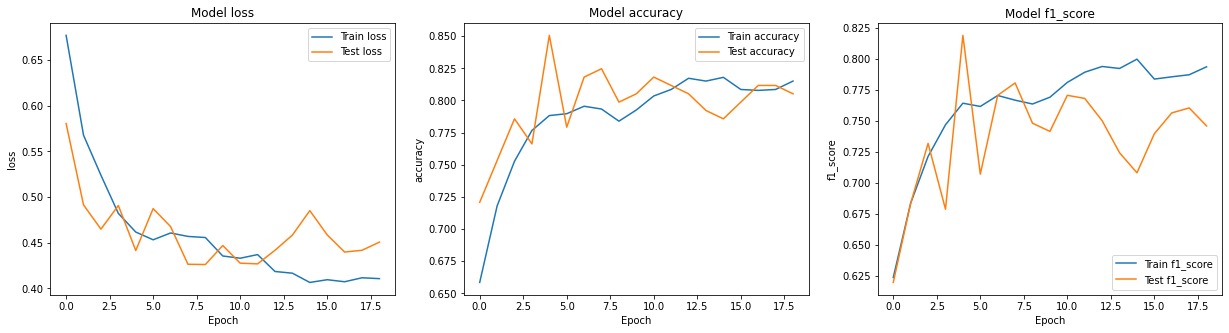

In [87]:
plot_prediction(model_45_config.epochs, model_4_log)

Evaluamos también el modelo obtenido sobre el conjunto de test:

In [88]:
model_4_loss, model_4_accuracy, model_4_f1_score = model_45.evaluate(X_test, y_test, verbose=1);

6/6 [==============================] - 2s 155ms/step - loss: 0.4582 - accuracy: 0.8218 - f1_score: 0.8075


Y mostramos la matriz de confusión sobre datos de test:

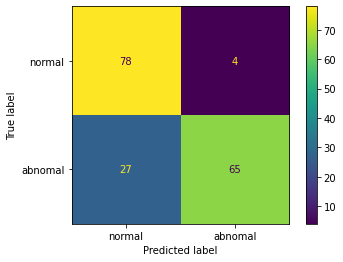

In [89]:
# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                        y_pred=model_45.predict(X_test) > ABNORMALITY_THRESHOLD, 
                                        display_labels=labels);

Cargamos los pesos del Modelo 4 ya entrenado:

In [90]:
model_45.load_weights(model_4_checkpoint_filepath)

Convertimos los últimos 2 bloques del modelo base (la *VGG-19*) en entrenables:

In [91]:
make_base_models_last_n_layers_trainable(model=model_45, 
                                         base_model_name=model_45_config.base_model_name, 
                                         n_layers=5*model_45_config.fine_tuned_blocks)

Mostramos que efectivamente ahora estas capas sí son entrenables:

In [92]:
for layer in model_45.get_layer(name=model_45_config.base_model_name).layers:
  print(layer.name, ":", layer.trainable)

input_8 : False
block1_conv1 : False
block1_conv2 : False
block1_pool : False
block2_conv1 : False
block2_conv2 : False
block2_pool : False
block3_conv1 : False
block3_conv2 : False
block3_conv3 : False
block3_conv4 : False
block3_pool : False
block4_conv1 : True
block4_conv2 : True
block4_conv3 : True
block4_conv4 : True
block4_pool : True
block5_conv1 : True
block5_conv2 : True
block5_conv3 : True
block5_conv4 : True
block5_pool : True


Volvemos a compilar el modelo:

In [93]:
# Compile for fine-tuning:
model_45.compile(loss=model_45_config.loss_function, 
                  optimizer=SGD(learning_rate=model_45_config.fine_tuning_lr,
                                momentum=model_45_config.fine_tuning_momentum, 
                                clipnorm=model_45_config.fine_tuning_clipnorm), 
                  metrics=['accuracy', F1Score(num_classes=2, average='micro', threshold=ABNORMALITY_THRESHOLD)])

Creamos el *Model Checkpoint Callback* que guardará los pesos de la mejor época durante el entrenamiento:

In [94]:
model_5_checkpoint_filepath = path.join(MODELS_DIR, 'model_5')
model_5_checkpoint_callback = get_model_checkpoint(model_5_checkpoint_filepath)

Y entrenamos el modelo:

In [95]:
# Fine-tuning:
model_5_log = model_45.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=model_45_config.fine_tuning_epochs,
                    batch_size=model_45_config.batch_size,
                    callbacks=[model_5_checkpoint_callback, 
                               EarlyStopping(monitor='val_loss', mode="min", patience=model_45_config.early_stopping_p2),
                               WandbCallback(monitor="val_f1_score", mode='max', save_model=False)])

Epoch 1/50
87/87 [==============================] - 20s 203ms/step - loss: 0.4430 - accuracy: 0.8020 - f1_score: 0.7793 - val_loss: 0.4992 - val_accuracy: 0.8312 - val_f1_score: 0.7869 - _timestamp: 1654759390.0000 - _runtime: 160.0000
Epoch 2/50
87/87 [==============================] - 8s 88ms/step - loss: 0.3819 - accuracy: 0.8318 - f1_score: 0.8170 - val_loss: 1.6958 - val_accuracy: 0.6558 - val_f1_score: 0.4045 - _timestamp: 1654759398.0000 - _runtime: 168.0000
Epoch 3/50
87/87 [==============================] - 8s 89ms/step - loss: 0.3493 - accuracy: 0.8506 - f1_score: 0.8347 - val_loss: 1.2159 - val_accuracy: 0.7013 - val_f1_score: 0.5208 - _timestamp: 1654759406.0000 - _runtime: 176.0000
Epoch 4/50
87/87 [==============================] - 14s 158ms/step - loss: 0.3310 - accuracy: 0.8542 - f1_score: 0.8403 - val_loss: 0.5266 - val_accuracy: 0.7922 - val_f1_score: 0.8072 - _timestamp: 1654759419.0000 - _runtime: 189.0000
Epoch 5/50
87/87 [==============================] - 8s 88ms/

Cargamos la época con el mejor resultado:

In [96]:
model_45.load_weights(model_5_checkpoint_filepath)

Dibujamos las gráficas de *loss*, *accuracy* y *F1-Score*:

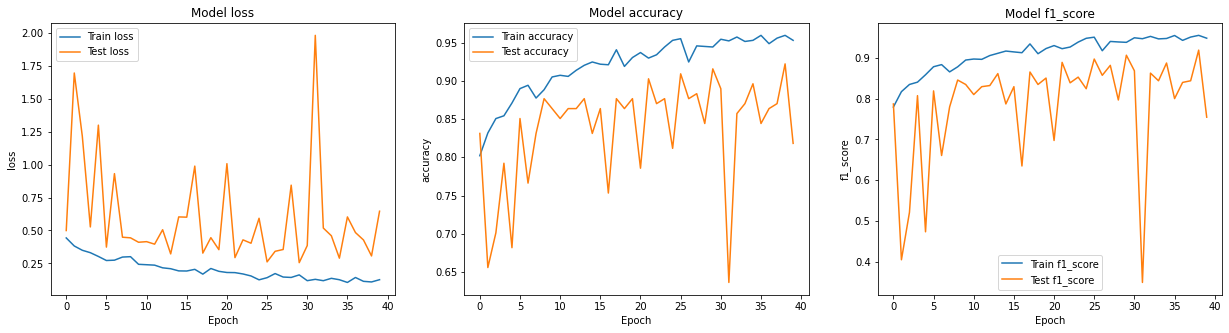

In [97]:
plot_prediction(model_45_config.fine_tuning_epochs, model_5_log)

Evaluamos también el modelo obtenido sobre el conjunto de test:

In [98]:
model_5_loss, model_5_accuracy, model_5_f1_score = model_45.evaluate(X_test, y_test, verbose=1);

6/6 [==============================] - 1s 81ms/step - loss: 0.2324 - accuracy: 0.9310 - f1_score: 0.9362


Y mostramos la matriz de confusión sobre datos de test:

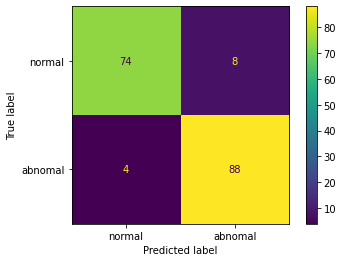

In [99]:
# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                        y_pred=model_45.predict(X_test) > ABNORMALITY_THRESHOLD, 
                                        display_labels=labels);

Y por último registramos los resultados y concluímos el experimento:

In [100]:
wandb.log({'test_loss': round(model_5_loss, 2),
           'test_accuracy': round(model_5_accuracy, 2),
           'test_f1_score': round(model_5_f1_score, 2)})

In [101]:
model_45_run.finish()

accuracy,▁▂▃▄▄▄▄▄▅▅▅▅▅▄▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇███████████
epoch,▁▁▁▂▂▂▂▃▃▃▄▄▄▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
f1_score,▁▂▃▄▄▄▄▄▅▅▅▄▄▄▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇███████████
loss,█▇▆▅▅▅▅▅▅▅▅▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_f1_score,▁
test_loss,▁
val_accuracy,▃▄▅▆▅▆▅▆▅▅▅▅▅▆▂▅▂▄▆▇▆▇▇▇▄▇▇█▇▅█▇▆▇▁▇█▇▇▆
val_f1_score,▄▅▆▇▆▇▆▆▆▆▆▆▆▇▂▇▃▅▇▇▇▇█▇▅▇▇█▇▇██▇█▁▇█▇▇▆
val_loss,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▇▂▅▄▂▂▂▂▁▂▄▂▁▁▂▂▁▁▃▂█▂▁▂▂▃
accuracy,0.95286


## 3. Validación cruzada

Definimos la función `trained_VGG10_transfer_model()`, que partiendo de configuración y datos reproduce el proceso necesario para generar el Modelo 5, nuestro mejor modelo:

In [102]:
def trained_VGG10_transfer_model(fold: str, config,
                                 train_X: np.ndarray, train_y: np.ndarray, 
                                 valid_X: np.ndarray, valid_y: np.ndarray):
  # Create the model:
  model = VGG19_transfer_model()
  # Compile and train transfer-learning model:
  model.compile(
      loss=config.loss_function, 
      optimizer=eval(config.optimizer)(learning_rate=config.learning_rate), 
      metrics=['accuracy', F1Score(num_classes=1, average='micro', threshold=ABNORMALITY_THRESHOLD)])
  # Model checkpoint callback:
  model_checkpoint_filepath = path.join(MODELS_DIR, "CV", f'model_{fold}')
  model_checkpoint_callback = get_model_checkpoint(model_checkpoint_filepath)
  # Training of classification layers:
  log = model.fit(
      train_X, train_y,
      validation_data=(valid_X, valid_y),
      epochs=config.epochs,
      batch_size=config.batch_size,
      callbacks=[model_checkpoint_callback, 
                 EarlyStopping(monitor='val_loss', mode="min", 
                               patience=config.early_stopping_p1),
                 WandbCallback(monitor="val_f1_score", mode='max', 
                               save_model=False)],
      verbose=0
  )
  model_ft_checkpoint_filepath = path.join(MODELS_DIR, "CV", f'model_{fold}_ft')
  model_ft_checkpoint_callback = get_model_checkpoint(model_ft_checkpoint_filepath)
  # Loading best epoch:
  model.load_weights(model_checkpoint_filepath)
  # Unfreezing model for fine-tuning:
  make_base_models_last_n_layers_trainable(
      model=model, 
      base_model_name=config.base_model_name, 
      n_layers=5*config.fine_tuned_blocks)
  # Compiling model for fine-tuning:
  model.compile(loss=config.loss_function, 
                optimizer=SGD(learning_rate=config.fine_tuning_lr,
                              momentum=config.fine_tuning_momentum, 
                              clipnorm=config.fine_tuning_clipnorm), 
                metrics=['accuracy', 
                         F1Score(num_classes=1, average='micro', threshold=ABNORMALITY_THRESHOLD)]
  )
  # Fine-tuning of base modelo layers:
  model_ft_log = model.fit(
      train_X, train_y,
      validation_data=(valid_X, valid_y),
      epochs=config.fine_tuning_epochs,
      batch_size=config.batch_size,
      callbacks=[
      model_ft_checkpoint_callback, 
        EarlyStopping(monitor='val_loss', mode="min", 
                      patience=config.early_stopping_p2),
        WandbCallback(monitor="val_f1_score", mode='max', 
                      save_model=False)
      ],
      verbose=0
  )
  # Loading best model:
  model.load_weights(model_ft_checkpoint_filepath)
  return model

Con el entrenamiento del Modelo 5 convenientemente empaquetado iniciamos la validación cruzada:

Starting with Fold0.


Training Fold0 model.
INFO:tensorflow:Assets written to: Models/CV/model_Fold0/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold0/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold0/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold0/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold0_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold0_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold0_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold0_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold0_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold0_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold0_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold0_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold0_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold0_ft/assets
Evaluating Fold0 model.


Starting with Fold1.


Training Fold1 model.
INFO:tensorflow:Assets written to: Models/CV/model_Fold1/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold1/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold1/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold1/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold1/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold1/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold1/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold1/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold1/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold1_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold1_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold1_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold1_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold1_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold1_ft/assets


Starting with Fold2.


Training Fold2 model.
INFO:tensorflow:Assets written to: Models/CV/model_Fold2/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold2/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold2/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold2/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold2/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold2/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold2_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold2_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold2_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold2_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold2_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold2_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold2_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold2_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold2_f

Starting with Fold3.


Training Fold3 model.
INFO:tensorflow:Assets written to: Models/CV/model_Fold3/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold3/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold3/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold3/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold3/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold3/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold3/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold3/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold3_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold3_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold3_ft/assets
Evaluating Fold3 model.


Starting with Fold4.


Training Fold4 model.
INFO:tensorflow:Assets written to: Models/CV/model_Fold4/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold4/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold4/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold4/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold4/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold4/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold4_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold4_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold4_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold4_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold4_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold4_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold4_ft/assets
Evaluating Fold4 model.


Starting with Fold5.


Training Fold5 model.
INFO:tensorflow:Assets written to: Models/CV/model_Fold5/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold5/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold5/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold5/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold5/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold5/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold5/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold5_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold5_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold5_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold5_ft/assets
Evaluating Fold5 model.


Starting with Fold6.


Training Fold6 model.
INFO:tensorflow:Assets written to: Models/CV/model_Fold6/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold6/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold6/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold6/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold6/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold6/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold6/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold6/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold6/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold6/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold6/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold6/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold6/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold6_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold6_ft/assets
INFO:tensorf

Starting with Fold7.


Training Fold7 model.
INFO:tensorflow:Assets written to: Models/CV/model_Fold7/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold7/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold7/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold7/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold7/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold7/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold7/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold7/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold7/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold7/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold7/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold7/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold7_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold7_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold7_ft/assets
INFO:tens

Starting with Fold8.


Training Fold8 model.
INFO:tensorflow:Assets written to: Models/CV/model_Fold8/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold8/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold8/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold8/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold8/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold8/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold8_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold8_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold8_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold8_ft/assets
Evaluating Fold8 model.


Starting with Fold9.


Training Fold9 model.
INFO:tensorflow:Assets written to: Models/CV/model_Fold9/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold9/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold9/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold9/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold9/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold9/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold9_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold9_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold9_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold9_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold9_ft/assets
INFO:tensorflow:Assets written to: Models/CV/model_Fold9_ft/assets
Evaluating Fold9 model.


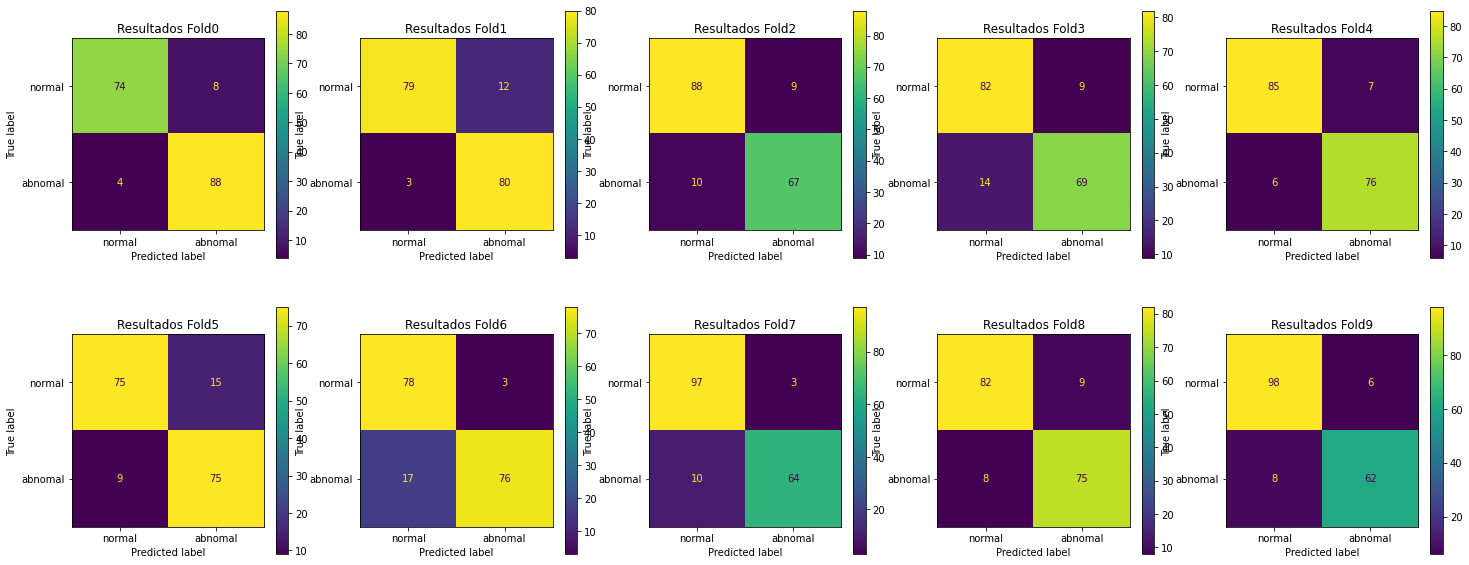

In [103]:
# Setting plot:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
# Initializing results array:
results = []
# Setting seeds:
set_all_seeds(40)
for i, ax in enumerate(axes.flat):
    fold_i = f"Fold{i}"
    print(f"Starting with {fold_i}.")
    # Obteniendo los datos del fold:
    (X_train, y_train), (X_valid, y_valid), (X_test, y_test) = read_glaucoma_fold_dataset(fold=fold_i)
    # Iniciamos el experimento y su seguimiento a través de Weights & Biases:
    run = wandb.init(project='Practica-DL-CV Modelo VGG19',
                     name=fold_i,
                  config={
                      "optimizer": 'Adam',
                      "learning_rate": 0.001,
                      "epochs": 100,
                      "batch_size": 16,
                      'early_stopping_p1': 10,
                      "loss_function": "binary_crossentropy",
                      'data_augmentation': DATA_AUGMENTATION,
                      'base_model_name': 'vgg19',
                      'fine_tuned_blocks': 2,
                      'fine_tuning_epochs': 50,
                      'fine_tuning_lr': 0.001, 
                      'fine_tuning_momentum': 0.9,
                      'fine_tuning_clipnorm': 1,
                      'early_stopping_p2': 10
                      })
    print(f"Training {fold_i} model.")
    # Creamos y entrenamos el modelo de transfer-learning y posterior fine-tuning:
    model = trained_VGG10_transfer_model(
        fold=fold_i,
        config=wandb.config,
        train_X=X_train,
        train_y=y_train,
        valid_X=X_valid,
        valid_y=y_valid
    )
    # Evaluamos el modelo obtenido:
    print(f"Evaluating {fold_i} model.")
    train_loss, train_accuracy, train_f1_score = model.evaluate(X_train, y_train, verbose=0)
    validation_loss, validation_accuracy, validation_f1_score = model.evaluate(X_valid, y_valid, verbose=0)
    test_loss, test_accuracy, test_f1_score = model.evaluate(X_test, y_test, verbose=0)
    # Registramos los resultados:
    fold_results = {
        'fold': fold_i,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'train_f1_score': train_f1_score,
        'validation_loss': validation_loss,
        'validation_accuracy': validation_accuracy,
        'validation_f1_score': validation_f1_score,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_f1_score': test_f1_score
    }
    wandb.log({
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_f1_score': test_f1_score
    })
    # Finalizamos el experimento:
    run.finish(quiet=True)
    # Guardamos los resultados del fold:
    results.append(fold_results)
    # Dibujamos la matriz de confusión:
    ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                            y_pred=model.predict(X_test) > ABNORMALITY_THRESHOLD, 
                                            display_labels=labels,
                                            ax=ax)
    ax.set_title(f"Resultados {fold_i}")
# Creamos una dataframe con los resultados de todos los folds:
results_df = pd.DataFrame.from_records(results)

Mostramos los resultados de cada *fold* en bruto:

In [104]:
results_df

,fold,train_loss,train_accuracy,train_f1_score,validation_loss,validation_accuracy,validation_f1_score,test_loss,test_accuracy,test_f1_score
0,Fold0,0.084911,0.968818,0.966485,0.306289,0.922078,0.918919,0.232393,0.931035,0.936170
1,Fold1,0.161069,0.945007,0.943114,0.240984,0.909091,0.900000,0.186037,0.913793,0.914286
2,Fold2,0.033978,0.990620,0.989977,0.119249,0.967532,0.965517,0.340172,0.890805,0.875817
3,Fold3,0.180579,0.934735,0.929022,0.317652,0.902597,0.893617,0.361310,0.867816,0.857143
4,Fold4,0.089883,0.968093,0.964516,0.264928,0.928571,0.921986,0.183780,0.925287,0.921212
5,Fold5,0.190192,0.933285,0.926282,0.300638,0.902597,0.910180,0.350556,0.862069,0.862069
6,Fold6,0.155246,0.947063,0.938707,0.184529,0.935065,0.924242,0.327261,0.885057,0.883721
7,Fold7,0.135896,0.951414,0.946614,0.255496,0.935065,0.927536,0.240171,0.925287,0.907801
8,Fold8,0.162503,0.945613,0.939074,0.249804,0.909091,0.905405,0.307684,0.902299,0.898204
9,Fold9,0.131054,0.950689,0.945687,0.318954,0.922078,0.915493,0.236723,0.919540,0.898551


Y tambien los resultados resumidos a intervalo:

In [105]:
for col in results_df.columns[1:]:
  col_mean = results_df[col].mean()
  col_std = results_df[col].std()
  print(f"Mean {col}: {round(col_mean, 2)} +- {round(col_std, 2)}")

Mean train_loss: 0.13 +- 0.05
Mean train_accuracy: 0.95 +- 0.02
Mean train_f1_score: 0.95 +- 0.02
Mean validation_loss: 0.26 +- 0.06
Mean validation_accuracy: 0.92 +- 0.02
Mean validation_f1_score: 0.92 +- 0.02
Mean test_loss: 0.28 +- 0.07
Mean test_accuracy: 0.9 +- 0.02
Mean test_f1_score: 0.9 +- 0.03


## Anexo: modelo de *transfer-learning* + *fine-tuning* a partir de Xception

In [106]:
from tensorflow.keras.applications import xception

In [107]:
def Xception_transfer_model():
  inputs = Input(shape=IMAGES_SHAPE)
  if DATA_AUGMENTATION:
    data_augmentation_model = data_augmentation_pipeline()
    augmented_inputs = data_augmentation_model(inputs)
  else:
    augmented_inputs = inputs
  preprocessed_inputs = xception.preprocess_input(augmented_inputs)
  # We get the Efficient Net:
  base_model = xception.Xception(
    include_top=False, # Do not include the ImageNet classifier at the top.
    weights="imagenet", # Load weights pre-trained on ImageNet.
    input_shape=IMAGES_SHAPE # Shape of the data,
  )
  # We set the Efficient Net to not trainable:
  base_model.trainable = False
  # We add the new layers on top:
  new_layers = base_model(augmented_inputs, training=False)
  new_layers = GlobalAveragePooling2D()(new_layers)
  new_layers = BatchNormalization()(new_layers)
  new_layers = Dropout(0.2)(new_layers)
  outputs = Dense(1, activation='sigmoid')(new_layers)
  model = Model(inputs=inputs, outputs=outputs)
  return model

In [108]:
# Initialize wandb with your project name
extra_model_run = wandb.init(project='Practica-DL-Modelo-Xception',
                  config={  # and include hyperparameters and metadata
                      "optimizer": 'Adam',
                      "learning_rate": 0.0005,
                      "epochs": 100,
                      "batch_size": MAX_BATCH_SIZE,
                      'early_stopping_p1': 15,
                      "loss_function": "binary_crossentropy",
                      'model': 'model_Xception',
                      'data_augmentation': DATA_AUGMENTATION,
                      'base_model_name': 'xception',
                      'fine_tuned_layers': 16,
                      'fine_tuning_lr': 0.0001, 
                      'fine_tuning_momentum': 0.9,
                      'fine_tuning_clipnorm': 1,
                      'early_stopping_p2': 10
                  })
extra_model_config = wandb.config  # We'll use this to configure our experiment

In [109]:
set_all_seeds(50)

In [110]:
extra_model = Xception_transfer_model()

83697664/83683744 [==============================] - 1s 0us/step


In [111]:
# Compile
extra_model.compile(loss=extra_model_config.loss_function, 
                  optimizer=eval(extra_model_config.optimizer)(learning_rate=extra_model_config.learning_rate), 
                  metrics=['accuracy', F1Score(num_classes=2, average='micro', threshold=ABNORMALITY_THRESHOLD)])

In [112]:
extra_model_checkpoint_filepath = path.join(MODELS_DIR, 'extra_model')
extra_model_checkpoint_callback = get_model_checkpoint(extra_model_checkpoint_filepath)

In [113]:
# Entrenar el modelo
extra_model_log = extra_model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=extra_model_config.epochs,
                    batch_size=extra_model_config.batch_size,
                    callbacks=[extra_model_checkpoint_callback, 
                               EarlyStopping(monitor='val_loss', mode="min", patience=extra_model_config.early_stopping_p1),
                               WandbCallback(monitor="val_f1_score", mode='max', save_model=False)])

Epoch 1/100
44/44 [==============================] - 32s 637ms/step - loss: 0.7016 - accuracy: 0.5867 - f1_score: 0.5411 - val_loss: 0.6026 - val_accuracy: 0.6883 - val_f1_score: 0.6923 - _timestamp: 1654764725.0000 - _runtime: 43.0000
Epoch 2/100
43/44 [============================>.] - ETA: 0s - loss: 0.6320 - accuracy: 0.6562 - f1_score: 0.6201WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
INFO:tensorflow:Assets written to: Models/extra_model/assets
44/44 [==============================] - 29s 681ms/step - loss: 0.6327 - accuracy: 0.6555 - f1_score: 0.6197 - val_loss: 0.5539 - val_accuracy: 0.7468 - val_f1_score: 0.7516 - _timestamp: 1654764754.0000 - _runt

In [114]:
extra_model.load_weights(extra_model_checkpoint_filepath)

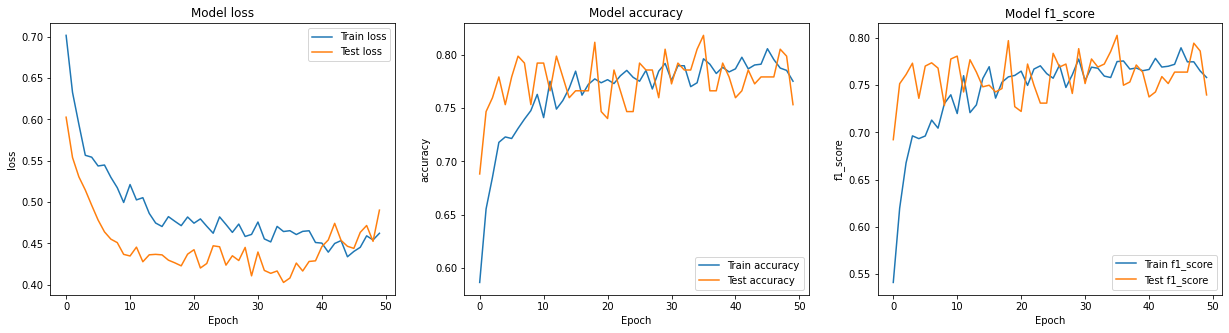

In [115]:
plot_prediction(100, extra_model_log)

In [116]:
extra_model_loss, extra_model_accuracy, extra_model_f1_score = extra_model.evaluate(X_test, y_test, verbose=1);

6/6 [==============================] - 1s 107ms/step - loss: 0.4423 - accuracy: 0.8103 - f1_score: 0.7442


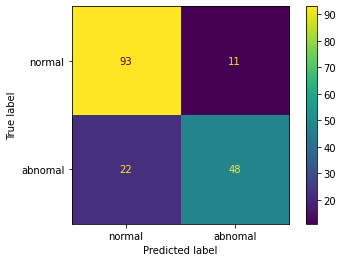

In [117]:
# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                        y_pred=extra_model.predict(X_test) > ABNORMALITY_THRESHOLD, 
                                        display_labels=labels);

In [118]:
make_base_models_last_n_layers_trainable(model=extra_model, 
                                         base_model_name=extra_model_config.base_model_name, 
                                         n_layers=extra_model_config.fine_tuned_layers)

In [119]:
for layer in extra_model.get_layer(name=extra_model_config.base_model_name).layers:
  print(layer.name, ":", layer.trainable)

input_30 : False
block1_conv1 : False
block1_conv1_bn : False
block1_conv1_act : False
block1_conv2 : False
block1_conv2_bn : False
block1_conv2_act : False
block2_sepconv1 : False
block2_sepconv1_bn : False
block2_sepconv2_act : False
block2_sepconv2 : False
block2_sepconv2_bn : False
conv2d : False
block2_pool : False
batch_normalization_14 : False
add : False
block3_sepconv1_act : False
block3_sepconv1 : False
block3_sepconv1_bn : False
block3_sepconv2_act : False
block3_sepconv2 : False
block3_sepconv2_bn : False
conv2d_1 : False
block3_pool : False
batch_normalization_15 : False
add_1 : False
block4_sepconv1_act : False
block4_sepconv1 : False
block4_sepconv1_bn : False
block4_sepconv2_act : False
block4_sepconv2 : False
block4_sepconv2_bn : False
conv2d_2 : False
block4_pool : False
batch_normalization_16 : False
add_2 : False
block5_sepconv1_act : False
block5_sepconv1 : False
block5_sepconv1_bn : False
block5_sepconv2_act : False
block5_sepconv2 : False
block5_sepconv2_bn : Fal

In [120]:
# Compile for fine-tuning:
extra_model.compile(loss=extra_model_config.loss_function, 
                  optimizer=SGD(learning_rate=extra_model_config.fine_tuning_lr,
                                momentum=extra_model_config.fine_tuning_momentum, 
                                clipnorm=extra_model_config.fine_tuning_clipnorm), 
                  metrics=['accuracy', F1Score(num_classes=2, average='micro', threshold=ABNORMALITY_THRESHOLD)])

In [121]:
# Fine-tuning:
extra_model_ft_log = extra_model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=50,
                    batch_size=extra_model_config.batch_size,
                    callbacks=[extra_model_checkpoint_callback, 
                               EarlyStopping(monitor='val_loss', mode="min", patience=extra_model_config.early_stopping_p2),
                               WandbCallback(monitor="val_f1_score", mode='max', save_model=False)])

Epoch 1/50
44/44 [==============================] - 11s 132ms/step - loss: 0.4612 - accuracy: 0.7970 - f1_score: 0.7806 - val_loss: 0.5398 - val_accuracy: 0.7662 - val_f1_score: 0.7097 - _timestamp: 1654765120.0000 - _runtime: 438.0000
Epoch 2/50
44/44 [==============================] - 5s 104ms/step - loss: 0.4773 - accuracy: 0.7788 - f1_score: 0.7589 - val_loss: 0.4558 - val_accuracy: 0.7922 - val_f1_score: 0.8000 - _timestamp: 1654765125.0000 - _runtime: 443.0000
Epoch 3/50
44/44 [==============================] - 5s 104ms/step - loss: 0.4391 - accuracy: 0.8122 - f1_score: 0.7959 - val_loss: 0.4816 - val_accuracy: 0.7662 - val_f1_score: 0.7465 - _timestamp: 1654765130.0000 - _runtime: 448.0000
Epoch 4/50
44/44 [==============================] - 5s 104ms/step - loss: 0.4635 - accuracy: 0.7788 - f1_score: 0.7597 - val_loss: 0.4737 - val_accuracy: 0.7727 - val_f1_score: 0.7244 - _timestamp: 1654765134.0000 - _runtime: 452.0000
Epoch 5/50
44/44 [==============================] - 5s 104m

In [122]:
extra_model.load_weights(extra_model_checkpoint_filepath)

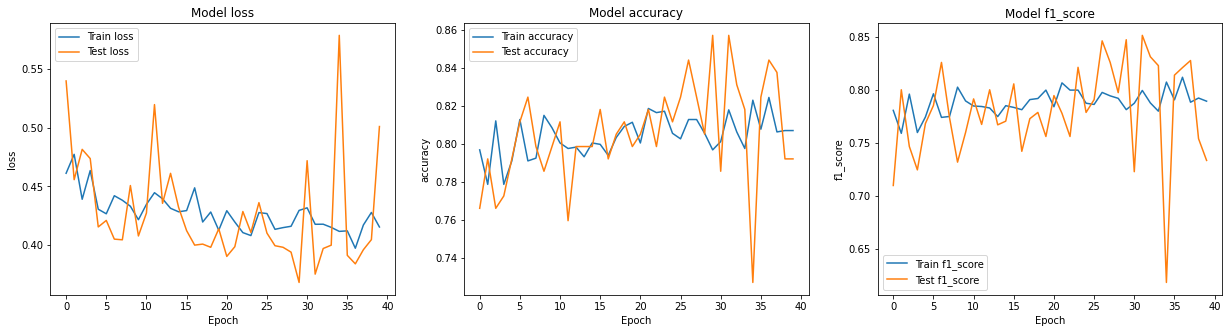

In [123]:
plot_prediction(100, extra_model_ft_log)

In [124]:
extra_model_loss, extra_model_accuracy, extra_model_f1_score = extra_model.evaluate(X_test, y_test, verbose=1);

6/6 [==============================] - 0s 68ms/step - loss: 0.4081 - accuracy: 0.8563 - f1_score: 0.8252


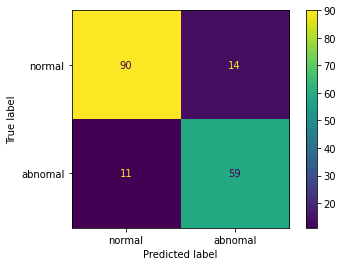

In [125]:
# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                        y_pred=extra_model.predict(X_test) > ABNORMALITY_THRESHOLD, 
                                        display_labels=labels);

In [126]:
wandb.log({'test_loss': round(extra_model_loss, 2),
           'test_accuracy': round(extra_model_accuracy, 2),
           'test_f1_score': round(extra_model_f1_score, 2)})

In [127]:
extra_model_run.finish()

accuracy,▁▄▅▅▆▇▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇█▇█▇█▇▇██▇
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇
f1_score,▁▄▅▅▆▇▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇█▇▇██▇
loss,█▆▅▄▃▃▃▃▃▃▃▃▃▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁
test_accuracy,▁
test_f1_score,▁
test_loss,▁
val_accuracy,▁▄▄▆▅▄▅▄▆▃▄▅▅▆▅▆▄▅▄▄▅▆▄▄▅▆▆▄▆▅▆▆▇▇▇█▇▃▇▅
val_f1_score,▃▅▅▆▆▅▅▅▆▄▅▆▆▆▆▆▅▆▅▅▅▆▄▅▆▆▅▆▆▅▆▆▇▆▇██▁▇▅
val_loss,█▆▅▄▃▃▃▃▃▃▃▃▃▂▂▂▃▃▄▄▃▄▆▄▂▂▂▆▄▂▂▂▂▂▂▁▂▇▁▅
accuracy,0.80711
